# Comparing Transformer Models
- Identify the best Transformer model which classifies offensive and non-offensive tweets accurately from 6,463 manually labeled tweets
- Models tested were:
    - cardiffnlp/twitter-roberta-base-offensive
    - cardiffnlp/twitter-roberta-base-dec2021-offensive
    - facebook/roberta-hate-speech-dynabench-r4-target
    - Falconsai/offensive_speech_detection

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
base_path = "/content/drive/MyDrive/MRP_Offensive_Content_Detection/Final_Dataset/"
dataset_name = "mrp_final_dataset.csv"
df = pd.read_csv(base_path + dataset_name)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6463 entries, 0 to 6462
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   text            6463 non-null   object
 1   majority_label  6463 non-null   object
dtypes: object(2)
memory usage: 101.1+ KB


In [ ]:
df.shape

(6463, 2)

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['label'] = le.fit_transform(df['majority_label'])  # Maps labels to integers

In [ ]:
df['label'].value_counts()

,count
label,
1,3584
0,2879


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from nltk.tokenize import TweetTokenizer
import torch
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
import pandas as pd
from datasets import Dataset
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np
import torch

In [ ]:
# 80% for training/validation, 20% final test
train_eval_df, final_test_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df['label']
)

# Split the 80%: 10% of it (8% total) for eval
train_df, eval_df = train_test_split(
    train_eval_df,
    test_size=0.1,
    random_state=42,
    stratify=train_eval_df['label']
)

print("Train size:", len(train_df))
print("Eval size:", len(eval_df))
print("Final test size:", len(final_test_df))

Train size: 4653
Eval size: 517
Final test size: 1293


In [ ]:
train_dataset = Dataset.from_pandas(train_df)
eval_dataset = Dataset.from_pandas(eval_df)
final_test_dataset = Dataset.from_pandas(final_test_df)

# Model 1: cardiffnlp/twitter-roberta-base-offensive

In [ ]:
tokenizer = RobertaTokenizer.from_pretrained('cardiffnlp/twitter-roberta-base-offensive')

# Tokenization function
def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=128)

# Tokenize datasets
tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_eval = eval_dataset.map(tokenize_function, batched=True)
tokenized_final_test = final_test_dataset.map(tokenize_function, batched=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

Map:   0%|          | 0/4653 [00:00<?, ? examples/s]

Map:   0%|          | 0/517 [00:00<?, ? examples/s]

Map:   0%|          | 0/1293 [00:00<?, ? examples/s]

In [ ]:
model = RobertaForSequenceClassification.from_pretrained(
    'cardiffnlp/twitter-roberta-base-offensive',
    num_labels=2
)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",            # Save every epoch (MUST MATCH)
    logging_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    save_total_limit=1,
    load_best_model_at_end=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_eval,
    compute_metrics=compute_metrics
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.416900,0.397267,0.806576,0.804073,0.809750,0.806576
2,0.244400,0.624034,0.810445,0.810070,0.810088,0.810445
3,0.133800,1.010054,0.806576,0.805578,0.806578,0.806576
4,0.067900,1.225994,0.808511,0.808285,0.808213,0.808511
5,0.040800,1.348132,0.796905,0.795632,0.797051,0.796905


TrainOutput(global_step=1455, training_loss=0.18074745034024478, metrics={'train_runtime': 569.2863, 'train_samples_per_second': 40.867, 'train_steps_per_second': 2.556, 'total_flos': 1530319675737600.0, 'train_loss': 0.18074745034024478, 'epoch': 5.0})

In [ ]:
print("Evaluating on final test set...")
final_test_results = trainer.evaluate(tokenized_final_test)
# Convert to DataFrame for pretty tabular display
results_df = pd.DataFrame(final_test_results.items(), columns=["Metric", "Value"])

# Set the metric as the index for a neater table
results_df.set_index("Metric", inplace=True)

print("Final Test Set Results:")
print(results_df)

Evaluating on final test set...


Final Test Set Results:
                              Value
Metric                             
eval_loss                  0.344531
eval_accuracy              0.836040
eval_f1                    0.833934
eval_precision             0.840328
eval_recall                0.836040
eval_runtime               8.285000
eval_samples_per_second  156.065000
eval_steps_per_second      9.777000
epoch                      5.000000


In [ ]:
# Get predictions and true labels
predictions_output = trainer.predict(tokenized_final_test)

# Logits → predicted labels
y_pred = np.argmax(predictions_output.predictions, axis=1)
y_true = predictions_output.label_ids

In [ ]:
# Print classification report for test set
print(classification_report(y_true, y_pred, target_names=le.classes_))

               precision    recall  f1-score   support

Non-offensive       0.87      0.74      0.80       576
    Offensive       0.81      0.91      0.86       717

     accuracy                           0.84      1293
    macro avg       0.84      0.83      0.83      1293
 weighted avg       0.84      0.84      0.83      1293



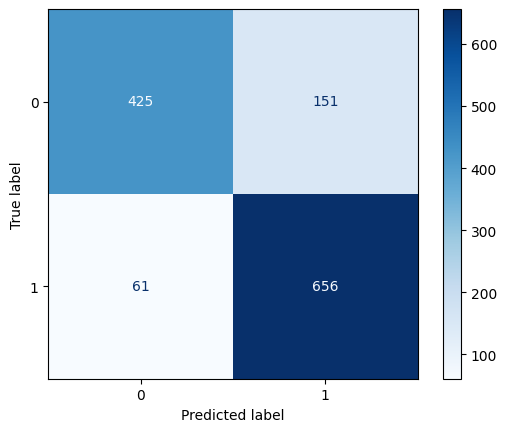

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')

# Model 2: cardiffnlp/twitter-roberta-base-dec2021-offensive

In [ ]:
tokenizer = RobertaTokenizer.from_pretrained('cardiffnlp/twitter-roberta-base-dec2021-offensive')

# Tokenization function
def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=128)

# Tokenize datasets
tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_eval = eval_dataset.map(tokenize_function, batched=True)
tokenized_final_test = final_test_dataset.map(tokenize_function, batched=True)

tokenizer_config.json:   0%|          | 0.00/407 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Map:   0%|          | 0/4653 [00:00<?, ? examples/s]

Map:   0%|          | 0/517 [00:00<?, ? examples/s]

Map:   0%|          | 0/1293 [00:00<?, ? examples/s]

In [ ]:
model = RobertaForSequenceClassification.from_pretrained(
    'cardiffnlp/twitter-roberta-base-dec2021-offensive',
    num_labels=2
)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",            # Save every epoch (MUST MATCH)
    logging_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    save_total_limit=1,
    load_best_model_at_end=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_eval,
    compute_metrics=compute_metrics
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [ ]:
trainer.train()

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.407400,0.372187,0.829787,0.829353,0.829550,0.829787
2,0.229700,0.578921,0.829787,0.829028,0.829892,0.829787
3,0.120400,0.992249,0.825919,0.825841,0.825788,0.825919
4,0.075600,1.095069,0.818182,0.818504,0.819440,0.818182
5,0.034200,1.167057,0.835590,0.835219,0.835361,0.835590


TrainOutput(global_step=1455, training_loss=0.1734415021548976, metrics={'train_runtime': 554.5186, 'train_samples_per_second': 41.955, 'train_steps_per_second': 2.624, 'total_flos': 1530319675737600.0, 'train_loss': 0.1734415021548976, 'epoch': 5.0})

In [ ]:
print("Evaluating on final test set...")
final_test_results = trainer.evaluate(tokenized_final_test)
# Convert to DataFrame for pretty tabular display
results_df = pd.DataFrame(final_test_results.items(), columns=["Metric", "Value"])

# Set the metric as the index for a neater table
results_df.set_index("Metric", inplace=True)

print("Final Test Set Results:")
print(results_df)

Evaluating on final test set...


Final Test Set Results:
                              Value
Metric                             
eval_loss                  0.330317
eval_accuracy              0.855375
eval_f1                    0.854794
eval_precision             0.855644
eval_recall                0.855375
eval_runtime               8.300400
eval_samples_per_second  155.775000
eval_steps_per_second      9.759000
epoch                      5.000000


In [ ]:
# Get predictions and true labels
predictions_output = trainer.predict(tokenized_final_test)

# Logits → predicted labels
y_pred = np.argmax(predictions_output.predictions, axis=1)
y_true = predictions_output.label_ids

In [ ]:
# Print classification report for test set
print(classification_report(y_true, y_pred, target_names=le.classes_))

               precision    recall  f1-score   support

Non-offensive       0.86      0.81      0.83       576
    Offensive       0.85      0.90      0.87       717

     accuracy                           0.86      1293
    macro avg       0.86      0.85      0.85      1293
 weighted avg       0.86      0.86      0.85      1293



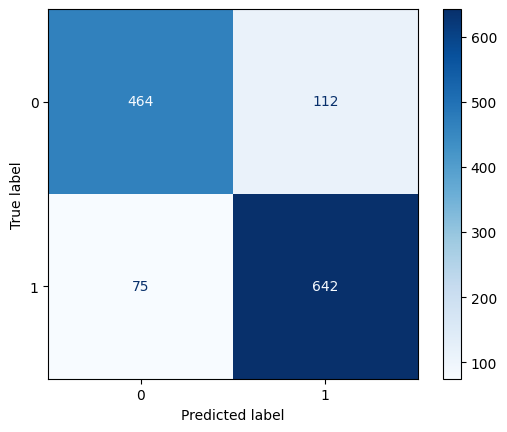

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')

# Model 3: facebook/roberta-hate-speech-dynabench-r4-target

In [ ]:
model_name = "facebook/roberta-hate-speech-dynabench-r4-target"
tokenizer = RobertaTokenizer.from_pretrained(model_name)
model = RobertaForSequenceClassification.from_pretrained(model_name, num_labels=2)

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/816 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [ ]:
# Tokenization function
def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=128)

# Tokenize datasets
tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_eval = eval_dataset.map(tokenize_function, batched=True)
tokenized_final_test = final_test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/4653 [00:00<?, ? examples/s]

Map:   0%|          | 0/517 [00:00<?, ? examples/s]

Map:   0%|          | 0/1293 [00:00<?, ? examples/s]

In [ ]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",            # Save every epoch (MUST MATCH)
    logging_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    save_total_limit=1,
    load_best_model_at_end=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_eval,
    compute_metrics=compute_metrics
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.461700,0.403083,0.812379,0.812859,0.815096,0.812379
2,0.275300,0.514987,0.814313,0.812614,0.815857,0.814313
3,0.178000,0.832128,0.818182,0.817718,0.817876,0.818182
4,0.121300,1.133721,0.806576,0.806397,0.806316,0.806576
5,0.086800,1.210788,0.810445,0.809962,0.810093,0.810445


TrainOutput(global_step=1455, training_loss=0.22460636387985597, metrics={'train_runtime': 586.426, 'train_samples_per_second': 39.673, 'train_steps_per_second': 2.481, 'total_flos': 1530319675737600.0, 'train_loss': 0.22460636387985597, 'epoch': 5.0})

In [ ]:
print("Evaluating on final test set...")
final_test_results = trainer.evaluate(tokenized_final_test)
# Convert to DataFrame for pretty tabular display
results_df = pd.DataFrame(final_test_results.items(), columns=["Metric", "Value"])

# Set the metric as the index for a neater table
results_df.set_index("Metric", inplace=True)

print("Final Test Set Results:")
print(results_df)

Evaluating on final test set...


Final Test Set Results:
                              Value
Metric                             
eval_loss                  0.373477
eval_accuracy              0.830626
eval_f1                    0.831114
eval_precision             0.834827
eval_recall                0.830626
eval_runtime               8.248400
eval_samples_per_second  156.758000
eval_steps_per_second      9.820000
epoch                      5.000000


In [ ]:
# Get predictions and true labels
predictions_output = trainer.predict(tokenized_final_test)

# Logits → predicted labels
y_pred = np.argmax(predictions_output.predictions, axis=1)
y_true = predictions_output.label_ids

In [ ]:
# Print classification report for test set
print(classification_report(y_true, y_pred, target_names=le.classes_))

               precision    recall  f1-score   support

Non-offensive       0.78      0.86      0.82       576
    Offensive       0.88      0.81      0.84       717

     accuracy                           0.83      1293
    macro avg       0.83      0.83      0.83      1293
 weighted avg       0.83      0.83      0.83      1293



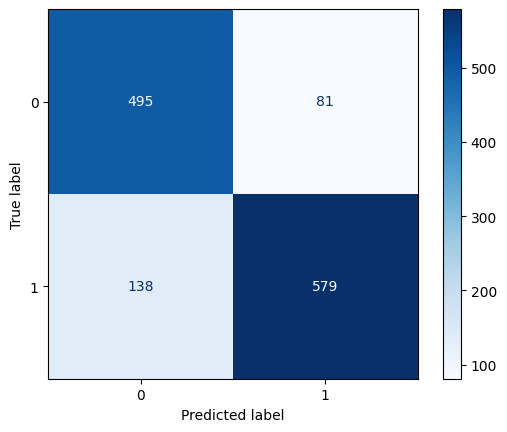

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')

# Model 4: Falconsai/offensive_speech_detection

In [ ]:
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# Load tokenizer and model
model_name = "Falconsai/offensive_speech_detection"
tokenizer = DistilBertTokenizerFast.from_pretrained(model_name)
model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=2)

# Tokenization function
def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=128)

# Tokenize datasets
tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_eval = eval_dataset.map(tokenize_function, batched=True)
tokenized_final_test = final_test_dataset.map(tokenize_function, batched=True)

# Compute metrics function
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

tokenizer_config.json:   0%|          | 0.00/320 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/742 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Map:   0%|          | 0/4653 [00:00<?, ? examples/s]

Map:   0%|          | 0/517 [00:00<?, ? examples/s]

Map:   0%|          | 0/1293 [00:00<?, ? examples/s]

In [ ]:
# Training arguments (adjust as needed)
training_args = TrainingArguments(
    output_dir="./results_falconsai",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    save_total_limit=1,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_eval,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# Train
trainer.train()

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.910200,0.509527,0.754352,0.752419,0.754101,0.754352
2,0.427200,0.495283,0.771760,0.770241,0.771580,0.771760
3,0.318900,0.569943,0.765957,0.766101,0.766296,0.765957
4,0.232400,0.717801,0.760155,0.759810,0.759673,0.760155
5,0.170000,0.868387,0.760155,0.760347,0.760630,0.760155


TrainOutput(global_step=1455, training_loss=0.41175180284428026, metrics={'train_runtime': 282.3982, 'train_samples_per_second': 82.384, 'train_steps_per_second': 5.152, 'total_flos': 770463507432960.0, 'train_loss': 0.41175180284428026, 'epoch': 5.0})

In [ ]:
# Evaluate on final test
print("Evaluating on final test set...")
final_test_results = trainer.evaluate(tokenized_final_test)
print(final_test_results)

# Get detailed classification report
predictions_output = trainer.predict(tokenized_final_test)
y_pred = np.argmax(predictions_output.predictions, axis=1)
y_true = predictions_output.label_ids

Evaluating on final test set...


{'eval_loss': 0.4704439640045166, 'eval_accuracy': 0.7788089713843774, 'eval_f1': 0.7774509185499309, 'eval_precision': 0.7786675493624158, 'eval_recall': 0.7788089713843774, 'eval_runtime': 4.6017, 'eval_samples_per_second': 280.985, 'eval_steps_per_second': 17.602, 'epoch': 5.0}


In [ ]:
# Print classification report for test set
print(classification_report(y_true, y_pred, target_names=le.classes_))

               precision    recall  f1-score   support

Non-offensive       0.78      0.71      0.74       576
    Offensive       0.78      0.84      0.81       717

     accuracy                           0.78      1293
    macro avg       0.78      0.77      0.77      1293
 weighted avg       0.78      0.78      0.78      1293



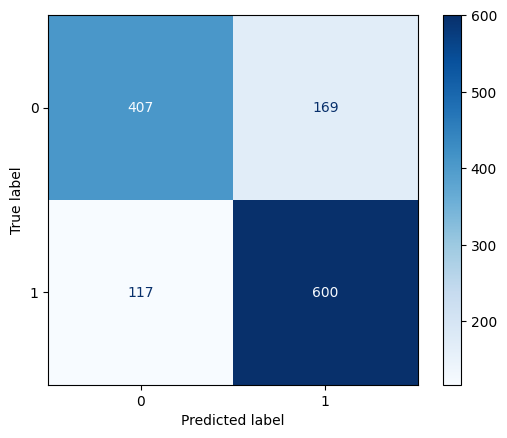

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')

#  Manual Hyper parameter tuning on model 2

# Reduce LR to 1e-5

In [ ]:
tokenizer = RobertaTokenizer.from_pretrained('cardiffnlp/twitter-roberta-base-dec2021-offensive')

# Tokenization function
def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=128)

# Tokenize datasets
tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_eval = eval_dataset.map(tokenize_function, batched=True)
tokenized_final_test = final_test_dataset.map(tokenize_function, batched=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/407 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Map:   0%|          | 0/4653 [00:00<?, ? examples/s]

Map:   0%|          | 0/517 [00:00<?, ? examples/s]

Map:   0%|          | 0/1293 [00:00<?, ? examples/s]

In [ ]:
model = RobertaForSequenceClassification.from_pretrained(
    'cardiffnlp/twitter-roberta-base-dec2021-offensive',
    num_labels=2
)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",            # Save every epoch (MUST MATCH)
    logging_strategy="epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    save_total_limit=1,
    load_best_model_at_end=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_eval,
    compute_metrics=compute_metrics
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.190900,0.674892,0.822050,0.821489,0.821828,0.822050
2,0.213600,0.603220,0.822050,0.820723,0.823046,0.822050
3,0.129200,0.928949,0.810445,0.808363,0.812741,0.810445
4,0.095500,1.018916,0.818182,0.817608,0.817931,0.818182
5,0.070200,1.057765,0.820116,0.818988,0.820637,0.820116


TrainOutput(global_step=1455, training_loss=0.13986116651816877, metrics={'train_runtime': 597.294, 'train_samples_per_second': 38.951, 'train_steps_per_second': 2.436, 'total_flos': 1530319675737600.0, 'train_loss': 0.13986116651816877, 'epoch': 5.0})

In [ ]:
print("Evaluating on final test set...")
final_test_results = trainer.evaluate(tokenized_final_test)
# Convert to DataFrame for pretty tabular display
results_df = pd.DataFrame(final_test_results.items(), columns=["Metric", "Value"])

# Optionally, set the metric as the index for a neater table
results_df.set_index("Metric", inplace=True)

print("Final Test Set Results:")
print(results_df)

Evaluating on final test set...


Final Test Set Results:
                              Value
Metric                             
eval_loss                  0.481628
eval_accuracy              0.847641
eval_f1                    0.846774
eval_precision             0.848405
eval_recall                0.847641
eval_runtime               8.399500
eval_samples_per_second  153.938000
eval_steps_per_second      9.643000
epoch                      5.000000


In [ ]:
# Get predictions and true labels
predictions_output = trainer.predict(tokenized_final_test)

# Logits → predicted labels
y_pred = np.argmax(predictions_output.predictions, axis=1)
y_true = predictions_output.label_ids

In [ ]:
# Print classification report for test set
print(classification_report(y_true, y_pred, target_names=le.classes_))

               precision    recall  f1-score   support

Non-offensive       0.86      0.79      0.82       576
    Offensive       0.84      0.90      0.87       717

     accuracy                           0.85      1293
    macro avg       0.85      0.84      0.84      1293
 weighted avg       0.85      0.85      0.85      1293



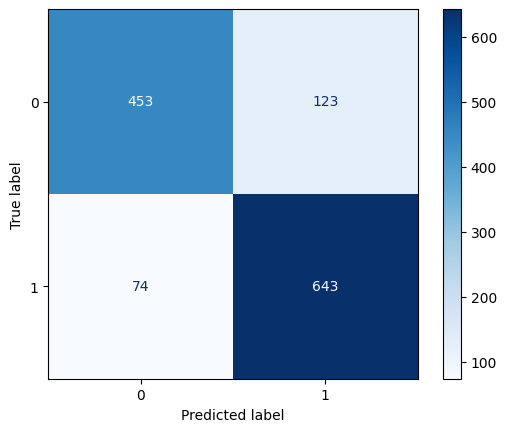

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')

# Increase LR to 3e-5

In [ ]:
tokenizer = RobertaTokenizer.from_pretrained('cardiffnlp/twitter-roberta-base-dec2021-offensive')

# Tokenization function
def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=128)

# Tokenize datasets
tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_eval = eval_dataset.map(tokenize_function, batched=True)
tokenized_final_test = final_test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/4653 [00:00<?, ? examples/s]

Map:   0%|          | 0/517 [00:00<?, ? examples/s]

Map:   0%|          | 0/1293 [00:00<?, ? examples/s]

In [ ]:
model = RobertaForSequenceClassification.from_pretrained(
    'cardiffnlp/twitter-roberta-base-dec2021-offensive',
    num_labels=2
)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",            # Save every epoch (MUST MATCH)
    logging_strategy="epoch",
    learning_rate=3e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    save_total_limit=1,
    load_best_model_at_end=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_eval,
    # tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.414900,0.383774,0.827853,0.827026,0.828028,0.827853
2,0.225400,0.586739,0.822050,0.821257,0.822070,0.822050
3,0.102300,1.040068,0.827853,0.827256,0.827724,0.827853
4,0.046800,1.213085,0.823985,0.824022,0.824065,0.823985
5,0.019200,1.271972,0.829787,0.829028,0.829892,0.829787


TrainOutput(global_step=1455, training_loss=0.16174040135649062, metrics={'train_runtime': 658.1601, 'train_samples_per_second': 35.349, 'train_steps_per_second': 2.211, 'total_flos': 1530319675737600.0, 'train_loss': 0.16174040135649062, 'epoch': 5.0})

In [ ]:
print("Evaluating on final test set...")
final_test_results = trainer.evaluate(tokenized_final_test)
# Convert to DataFrame for pretty tabular display
results_df = pd.DataFrame(final_test_results.items(), columns=["Metric", "Value"])

# Optionally, set the metric as the index for a neater table
results_df.set_index("Metric", inplace=True)

print("Final Test Set Results:")
print(results_df)

Evaluating on final test set...


Final Test Set Results:
                              Value
Metric                             
eval_loss                  0.340459
eval_accuracy              0.860789
eval_f1                    0.860174
eval_precision             0.861244
eval_recall                0.860789
eval_runtime               8.575700
eval_samples_per_second  150.774000
eval_steps_per_second      9.445000
epoch                      5.000000


In [ ]:
# Get predictions and true labels
predictions_output = trainer.predict(tokenized_final_test)

# Logits → predicted labels
y_pred = np.argmax(predictions_output.predictions, axis=1)
y_true = predictions_output.label_ids

In [ ]:
# Print classification report for test set
print(classification_report(y_true, y_pred, target_names=le.classes_))

               precision    recall  f1-score   support

Non-offensive       0.87      0.81      0.84       576
    Offensive       0.85      0.90      0.88       717

     accuracy                           0.86      1293
    macro avg       0.86      0.86      0.86      1293
 weighted avg       0.86      0.86      0.86      1293



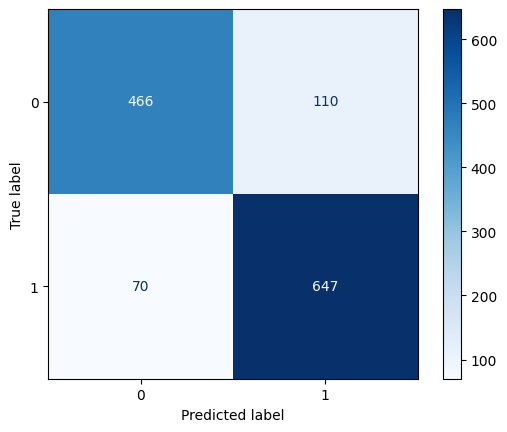

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')

# Increase LR to 4e-5

In [ ]:
tokenizer = RobertaTokenizer.from_pretrained('cardiffnlp/twitter-roberta-base-dec2021-offensive')

# Tokenization function
def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=128)

# Tokenize datasets
tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_eval = eval_dataset.map(tokenize_function, batched=True)
tokenized_final_test = final_test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/4653 [00:00<?, ? examples/s]

Map:   0%|          | 0/517 [00:00<?, ? examples/s]

Map:   0%|          | 0/1293 [00:00<?, ? examples/s]

In [ ]:
model = RobertaForSequenceClassification.from_pretrained(
    'cardiffnlp/twitter-roberta-base-dec2021-offensive',
    num_labels=2
)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",            # Save every epoch (MUST MATCH)
    logging_strategy="epoch",
    learning_rate=4e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    save_total_limit=1,
    load_best_model_at_end=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_eval,
    # tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.426400,0.394514,0.827853,0.826639,0.828797,0.827853
2,0.217000,0.579473,0.843327,0.843481,0.843793,0.843327
3,0.099800,0.962198,0.835590,0.835310,0.835340,0.835590
4,0.035500,1.260563,0.823985,0.824022,0.824065,0.823985
5,0.012600,1.260509,0.822050,0.821376,0.821929,0.822050


TrainOutput(global_step=1455, training_loss=0.15823848091859588, metrics={'train_runtime': 719.7181, 'train_samples_per_second': 32.325, 'train_steps_per_second': 2.022, 'total_flos': 1530319675737600.0, 'train_loss': 0.15823848091859588, 'epoch': 5.0})

In [ ]:
print("Evaluating on final test set...")
final_test_results = trainer.evaluate(tokenized_final_test)
# Convert to DataFrame for pretty tabular display
results_df = pd.DataFrame(final_test_results.items(), columns=["Metric", "Value"])

# Optionally, set the metric as the index for a neater table
results_df.set_index("Metric", inplace=True)

print("Final Test Set Results:")
print(results_df)

Evaluating on final test set...


Final Test Set Results:
                              Value
Metric                             
eval_loss                  0.353279
eval_accuracy              0.844548
eval_f1                    0.843322
eval_precision             0.846240
eval_recall                0.844548
eval_runtime               8.524900
eval_samples_per_second  151.673000
eval_steps_per_second      9.502000
epoch                      5.000000


In [ ]:
# Get predictions and true labels
predictions_output = trainer.predict(tokenized_final_test)

# Logits → predicted labels
y_pred = np.argmax(predictions_output.predictions, axis=1)
y_true = predictions_output.label_ids

In [ ]:
# Print classification report for test set
print(classification_report(y_true, y_pred, target_names=le.classes_))

               precision    recall  f1-score   support

Non-offensive       0.87      0.77      0.82       576
    Offensive       0.83      0.90      0.87       717

     accuracy                           0.84      1293
    macro avg       0.85      0.84      0.84      1293
 weighted avg       0.85      0.84      0.84      1293



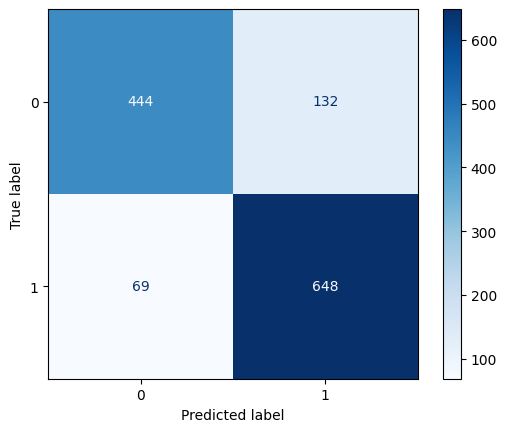

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')